In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.artist import Artist
import matplotlib as MPL
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from IPython.display import HTML

import numpy as np
from astropy.io import fits
from glob import glob
from datetime import datetime
import subprocess
from io import StringIO
from dataclasses import dataclass


In [2]:
fitsFiles = set(glob("../Sep04/pcoWideFocusTest_01_2022090*.fits")) - set(glob("../Sep04/*.xy.*"))
fileTimes = np.ndarray((len(fitsFiles), 1), dtype=datetime)

for idx, name in enumerate(fitsFiles):
    ns = name.split('_')
    ds = ns[2] + ns[3]
    ft = datetime.strptime(ds, "%Y%m%d%H%M%S.%f.fits")
    
    fileTimes[idx] = ft

sortedFileNames = np.asanyarray([x for _,x in sorted(zip(fileTimes, fitsFiles))])
print(sortedFileNames)

['../Sep04/pcoWideFocusTest_01_20220905_033333.607.fits'
 '../Sep04/pcoWideFocusTest_01_20220905_033333.857.fits'
 '../Sep04/pcoWideFocusTest_01_20220905_033334.057.fits' ...
 '../Sep04/pcoWideFocusTest_01_20220905_035940.975.fits'
 '../Sep04/pcoWideFocusTest_01_20220905_035941.175.fits'
 '../Sep04/pcoWideFocusTest_01_20220905_035941.325.fits']


In [5]:
for ii, tt in enumerate(sortedFileNames):
    if '034930' in tt:
        print(ii)

5119
5120
5121
5122
5123
5124


### Loop over N number of frames.
#### Store data, and source bboxes from image2xy and TSimag2xy

In [60]:
#==========================#
# set number of frames here
#==========================#
numFrames = 100

@dataclass
class xylist:
    sources: np.ndarray
    
    def __post_init__(self):
        
        self.sortedSources = self.sources[self.sources[:,2].argsort()[::-1]] # sort by flux
    
    def topNsources(self, numSources):
        return self.sortedSources[0:numSources, :]
    
def get_libtsSources(fname):
    
    tsLibTestCmd = "/home/viliam/thaiSpice/image2xyTesting/build/./testLib"
    procRes = subprocess.run([tsLibTestCmd, fname], capture_output=True, text=True)
    
    # print(type(procRes.stdout))
    # print(procRes.stdout)
    data = np.loadtxt(StringIO(procRes.stdout), delimiter=',', dtype=float)
    return xylist(data)
    # sortedByFlux = data[data[:,2].argsort()]

    
#==========================#
def imgStretchDisplay(imgData):
    
    md = np.mean(imgData)
    idmm = np.abs(imgData - md)
    idmm = np.float_power(idmm, 0.8)
    
    return idmm
#==========================#

#==========================#
# main loop
#==========================#

ims = []
xyIms = []

for idx, fname in enumerate(sortedFileNames[5119:]):
    
    print(f"Processing frame #: {idx:04d}", end='\r')
    
    with fits.open(fname) as img:
        imgData = img[0].data
        imgData = imgStretchDisplay(imgData)
        
        xy = get_libtsSources(fname)

        ims.append(imgData)
        xyIms.append(xy)
        
        if idx > numFrames:
            break


# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

In [61]:
print(xyIms)

[xylist(sources=array([[8.78542e+02, 6.23990e+02, 3.57128e+01, 3.78366e+02],
       [8.09657e+02, 1.15098e+02, 7.23160e+00, 3.76451e+02],
       [8.85389e+02, 7.13762e+02, 8.72308e+00, 3.78426e+02],
       [7.75423e+02, 5.66190e+02, 7.53745e+00, 3.77796e+02],
       [1.00100e+03, 1.90934e+02, 3.04163e+00, 3.78263e+02],
       [1.00350e+03, 3.37500e+02, 2.39532e+00, 3.78445e+02],
       [1.00305e+03, 4.13575e+02, 3.05722e+00, 3.78506e+02],
       [8.95242e+02, 9.00088e+02, 2.87784e+00, 3.78233e+02],
       [8.66167e+02, 8.30156e+02, 2.06088e+00, 3.78296e+02],
       [9.86061e+02, 4.96200e+02, 6.66620e+00, 3.78517e+02],
       [1.00238e+03, 2.61333e+02, 4.05127e+00, 3.78357e+02],
       [9.12519e+02, 3.44924e+02, 2.39444e+00, 3.78014e+02],
       [9.67129e+02, 7.34848e+02, 1.67938e+00, 3.78518e+02],
       [1.00390e+03, 8.96131e+01, 8.91327e-01, 3.78097e+02],
       [8.86856e+02, 4.28585e+02, 2.46542e+00, 3.78033e+02],
       [1.30765e+02, 8.03115e+02, 8.31262e+01, 3.78178e+02],
       [

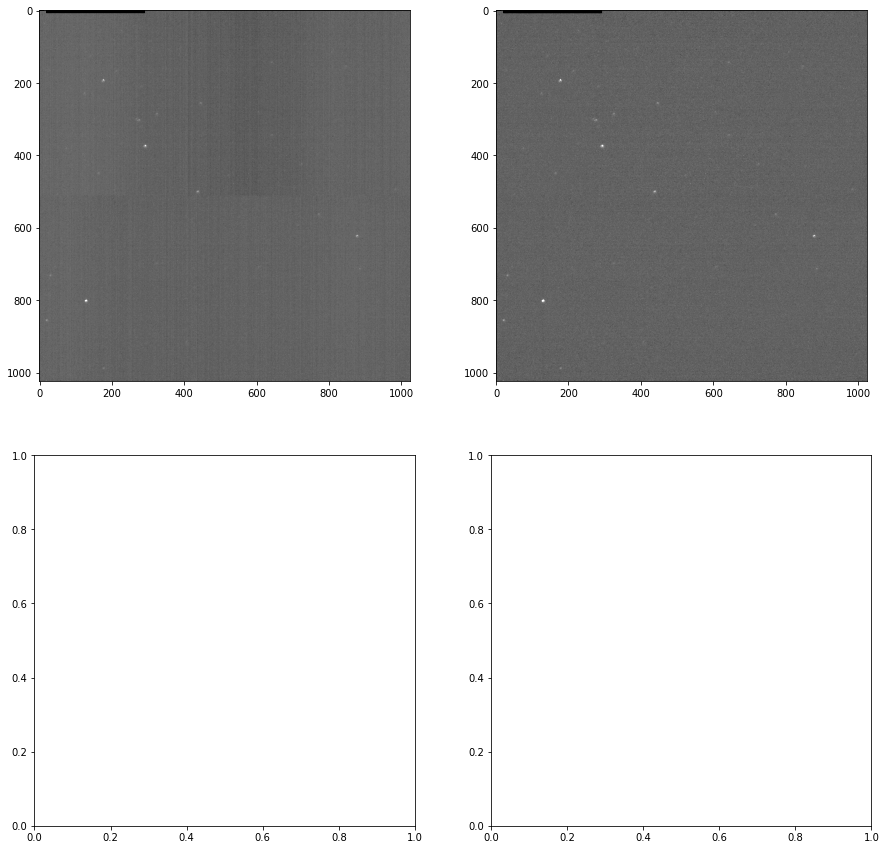

In [51]:
dd = fits.open(sortedFileNames[5119])
imgData = dd[0].data

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(imgData, cmap='gray', vmin=300, vmax=500)

colMeanRemove = np.copy(imgData)
for col in range(imgData.shape[1]):
    colMeanRemove[0:512, col] = imgData[0:512, col] - np.mean(imgData[10:512, col])
    colMeanRemove[512:, col] = imgData[512:, col] - np.mean(imgData[512:, col])
    # break

ax[0,1].imshow(colMeanRemove, cmap='gray', vmin=-50, vmax=80)

In [5]:
with open('xyIms.dat', 'wb') as ff:
    np.save(ff, xyIms, allow_pickle=True)

### Cell below does the animation

IndexError: list index out of range

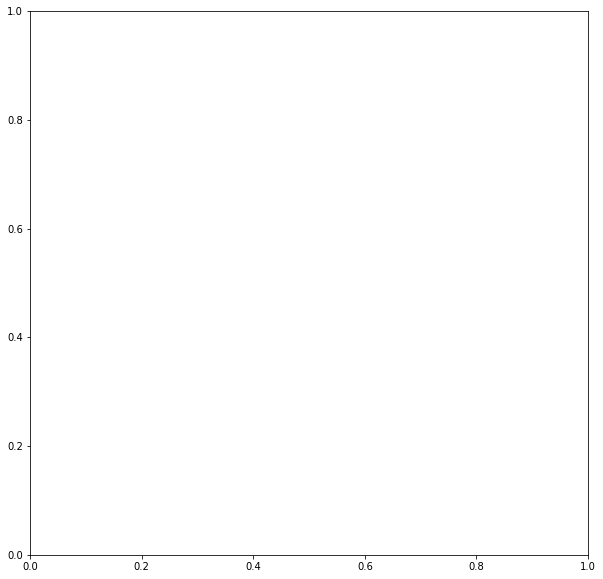

In [7]:
MPL.rcParams['animation.embed_limit'] = 100




fig, ax = plt.subplots(figsize=(10,10))
dataDisplay = ax.imshow(ims[0], vmax=50, vmin=0, animated=True);

# print(xyIms[0].topNsources(4))
# for xx in xyIms[0].topNsources(6):
#     print(xx[0:2])
boxSize = 80
bs2 = int(boxSize/2)

sBxs = [Rectangle((xx[0]-bs2, xx[1]-bs2), boxSize, boxSize) for xx in xyIms[0].topNsources(4)]
pc = PatchCollection(sBxs, facecolor='none', edgecolor='C1')
pcax = ax.add_collection(pc)

txtArtist = ax.text(50, 1000, f"Frame number: {idx:03d}",
            fontsize=15,
            color='white')
            
def animFrames(idx):
    
    global pcax
    
    dataDisplay.set_data(ims[idx])
    txtArtist.set_text(f"Frame number: {idx:03d}")
    
    # pcax.remove()
    
    # for rr in sBxs:
    #     rr.remove()
    # sBxs[0]
    
    recArray = [Rectangle((xx[0]-bs2, xx[1]-bs2), boxSize, boxSize) for xx in xyIms[idx].topNsources(4)]
    pc = PatchCollection(recArray, facecolor='none', edgecolor='C1')
    
    pcax.remove()
    pcax = ax.add_collection(pc)
    
    # rpc.remove()
    # vvs = pc.get_paths()
    # rpc.set_paths(vvs)
    # ax.add_collection(pc)
    # rpc.set(recArray)
    # rpc.set_array(recArray)
    # rpc.set_array
    
    return (dataDisplay, )

anim = animation.FuncAnimation(fig, animFrames, frames=numFrames, interval=50, blit=False);
HTML(anim.to_jshtml())